# pfceval | Basic evaluation template

This notebooks shows how to do a basic evaluation for two synthetic forecasts.

### Prepare Evaluation reports

In [1]:
import pfceval
import polars as pl

from dataclasses import dataclass

@dataclass
class BasicEvalConfig():
    index_cols = ["valid_time", "station_id", "step"]
    eval_ths = [9, 12]
    save_dir = "."
    lead_time_col = "step"
    location_id_col = "station_id"
    ensemble_prefix = "pred_q"
    obs_col = "wind_speed"
    bootstrap_col = "run_id"
    n_bootstrap_iter = 10
    CI = 0.9

    construct_eval_reports = True

config = BasicEvalConfig()


def get_basic_evaluation_report(forecast, experiment_name):

    calc = pfceval.Calculator(forecast, config.index_cols)
    calc.add_absolute_error()
    calc.add_squared_error()
    # Add probabilistic metrics
    calc.add_spread()
    calc.add_crps()
    # Add threshold based metrics
    for th in config.eval_ths:
        calc.add_twcrps(th)
        calc.add_brier(th)

    # fill_evaluation is a quick way to create an Evaluation.
    # Custom evaluations also can be done without using it.
    report = pfceval.Evaluation.fill_evaluation(
        experiment_name=experiment_name,
        calculator=calc, 
        lead_time_col=config.lead_time_col,
        location_id_col=config.location_id_col,
        bootstrap=True, 
        n_iter=config.n_bootstrap_iter, 
        CI=config.CI,
        location_metrics=True,
    )

    return report

# Generate psudo forecasts
forecast_paths = pfceval.utils.get_example_forecast_paths()

exp_names = []
for i, forecast_path in enumerate(forecast_paths):
    forecast = pfceval.Forecast(
        fc_path=forecast_path,
        ensemble_prefix=config.ensemble_prefix,
        obs_col=config.obs_col,
        bootstrap_cols=config.bootstrap_col,
        load_to_memory=True
    )

    exp_name = f"BasicEvaluationTemplate_{i}"
    exp_names.append(exp_name)
    report = get_basic_evaluation_report(
        forecast=forecast, 
        experiment_name=exp_name
    )
    # Get metrics for the stations that is present in training data
    seen_report = get_basic_evaluation_report(
        forecast=forecast.filter(pl.col("unseen_sta") == False), 
        experiment_name=exp_name
    )
    # Get metrics for the stations that is not present the training data
    unseen_report = get_basic_evaluation_report(
        forecast=forecast.filter(pl.col("unseen_sta") == True), 
        experiment_name=exp_name
    )
    # Get a common report for all filters by combining them
    # The reports on right will have the right_prefix in their tables
    report.extend(seen_report, right_prefix="seen")
    report.extend(unseen_report, right_prefix="unseen")
    # Save the report to disk
    report.save_results(f"{config.save_dir}/{exp_name}")

### Load the evaluation reports and analyze 

In [2]:
# Read reports from location
reports = [pfceval.Evaluation.load_report(f"./{path}") for path in exp_names]

overall = pfceval.plotting.stack_overall_metrics(*reports)
overall.sort("mae")

experiment,twcrps_th:9,brier_th:9,mse,twcrps_th:12,mae,brier_th:12,crps,spread
str,f64,f64,f64,f64,f64,f64,f64,f64
"""BasicEvaluationTemplate_0""",0.272457,0.000752,0.222335,0.253498,0.402261,0.017661,0.272862,0.446855
"""BasicEvaluationTemplate_1""",0.299946,0.001027,0.265607,0.278522,0.440428,0.020634,0.300466,0.445751


In [3]:
unseen_overall = pfceval.plotting.stack_overall_metrics(*reports, table_name="unseen_overall_metrics")
unseen_overall.sort("mae")

experiment,twcrps_th:9,brier_th:9,mse,twcrps_th:12,mae,brier_th:12,crps,spread
str,f64,f64,f64,f64,f64,f64,f64,f64
"""BasicEvaluationTemplate_0""",0.270684,0.000709,0.219746,0.251975,0.399422,0.018053,0.271009,0.445653
"""BasicEvaluationTemplate_1""",0.299997,0.000853,0.265305,0.277126,0.441636,0.01986,0.300507,0.447504


In [4]:
seen_overall = pfceval.plotting.stack_overall_metrics(*reports, table_name="seen_overall_metrics")
seen_overall.sort("mae")

experiment,twcrps_th:9,brier_th:9,mse,twcrps_th:12,mae,brier_th:12,crps,spread
str,f64,f64,f64,f64,f64,f64,f64,f64
"""BasicEvaluationTemplate_0""",0.273639,0.000781,0.224062,0.254513,0.404153,0.017399,0.274098,0.447656
"""BasicEvaluationTemplate_1""",0.299912,0.001143,0.265808,0.279453,0.439624,0.02115,0.30044,0.444583


/Users/harunkivril/Workspace/DEODE/pfceval/pfceval/plotting.py:193: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


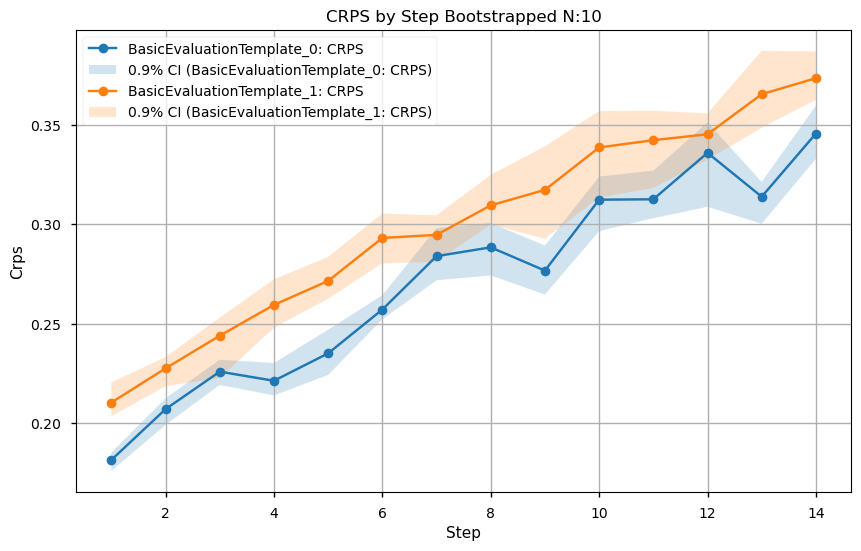

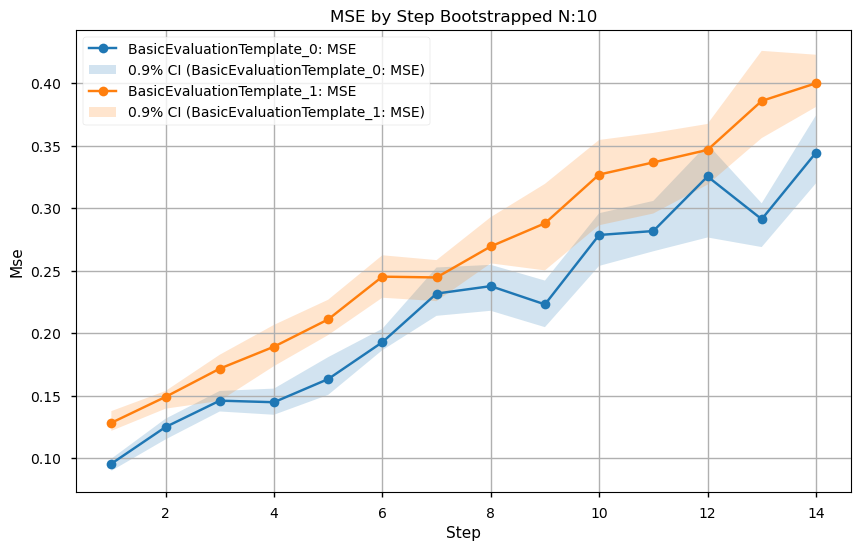

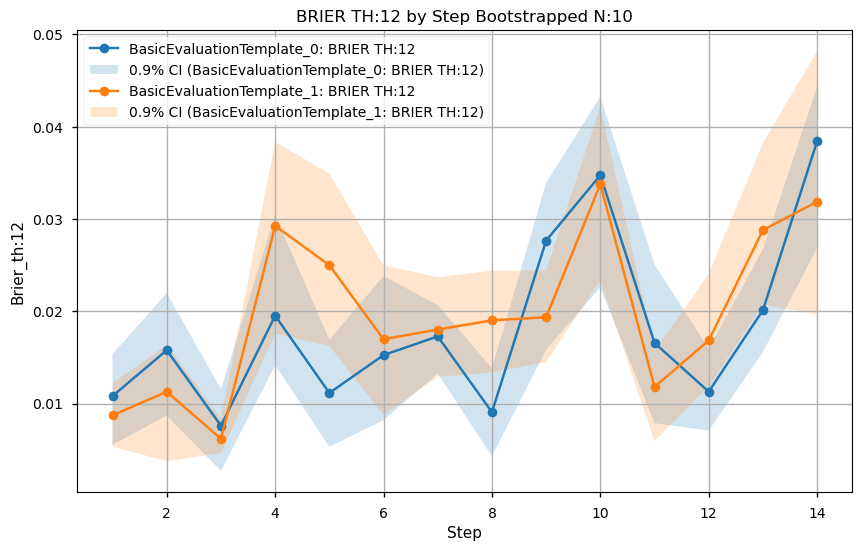

In [5]:
pfceval.plotting.plot_lead_time_metrics(*reports, table_name="unseen_bootstraped_lead_time_metrics", metrics=["crps", "mse", "brier_th:12"])

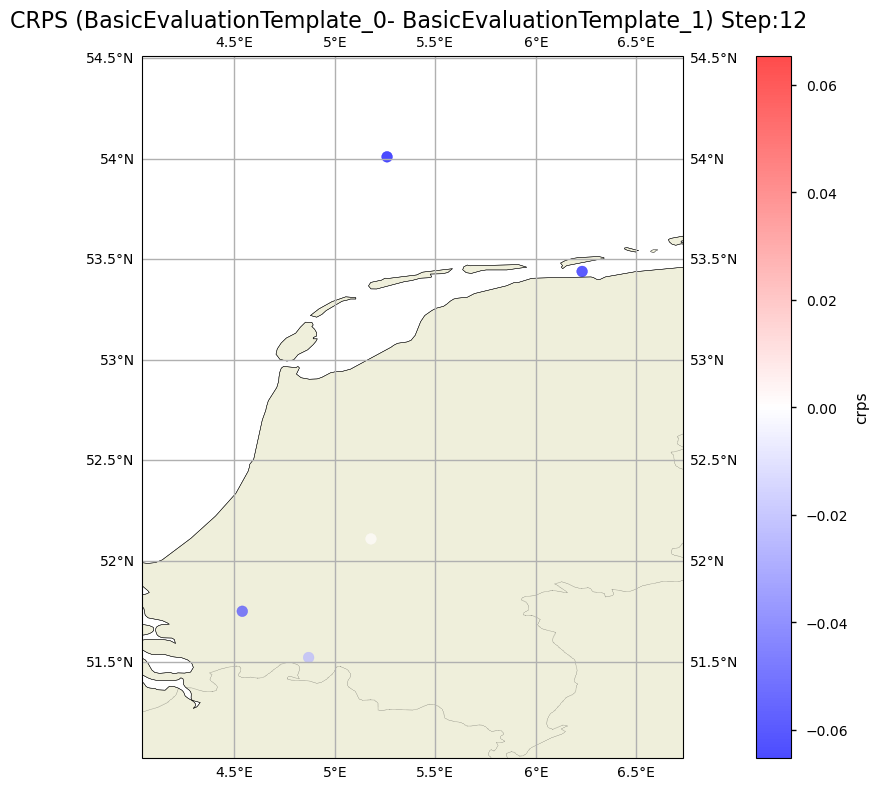

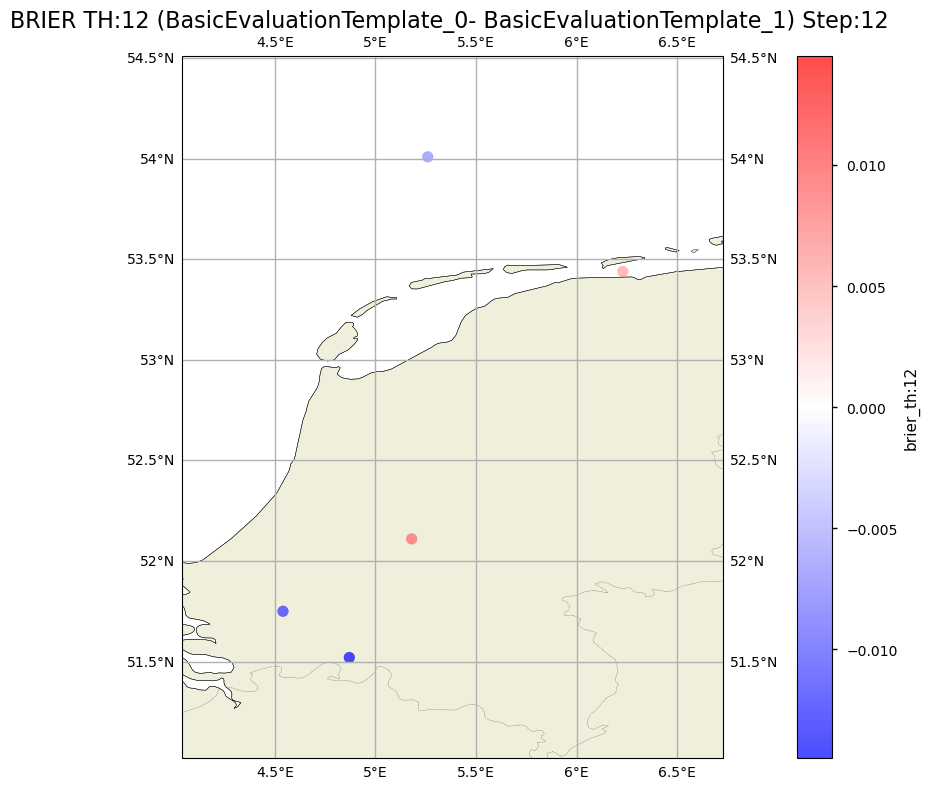

In [6]:
pfceval.plotting.plot_location_metrics(
    step=12, 
    evaluation=reports[0], 
    compare_with=reports[1], 
    metrics=["crps", "brier_th:12"], 
    cmap="bwr", 
    dot_size=60, 
    tol=0.5,
)

/Users/harunkivril/Workspace/DEODE/pfceval/pfceval/plotting.py:550: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


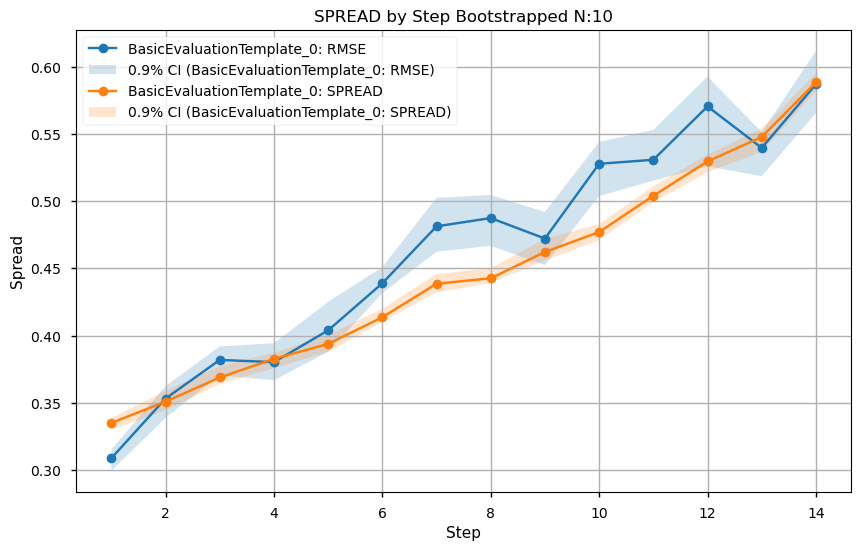

In [7]:
pfceval.plotting.plot_spread_rmse(reports[0], table_name="unseen_bootstraped_lead_time_metrics")

In [8]:
reports[0].tables()

['overall_metrics',
 'lead_time_metrics',
 'lead_time_location_metrics',
 'station_meta',
 'bootstraped_lead_time_metrics',
 'seen_overall_metrics',
 'seen_lead_time_metrics',
 'seen_lead_time_location_metrics',
 'seen_station_meta',
 'seen_bootstraped_lead_time_metrics',
 'unseen_overall_metrics',
 'unseen_lead_time_metrics',
 'unseen_lead_time_location_metrics',
 'unseen_station_meta',
 'unseen_bootstraped_lead_time_metrics']

In [9]:
reports[0]["unseen_bootstraped_lead_time_metrics"]

{'values': shape: (14, 25)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ step      ┆ brier_th: ┆ brier_th: ┆ brier_th: ┆ … ┆ twcrps_th ┆ twcrps_th ┆ twcrps_th ┆ twcrps_t │
 │ ---       ┆ 12_mean   ┆ 12_q005   ┆ 12_q095   ┆   ┆ :12_q095  ┆ :9_mean   ┆ :9_q005   ┆ h:9_q095 │
 │ duration[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
 │ μs]       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ 1h        ┆ 0.01081   ┆ 0.005542  ┆ 0.015352  ┆ … ┆ 0.175302  ┆ 0.181226  ┆ 0.175721  ┆ 0.184936 │
 │ 2h        ┆ 0.015778  ┆ 0.008693  ┆ 0.021979  ┆ … ┆ 0.201823  ┆ 0.206858  ┆ 0.198931  ┆ 0.212317 │
 │ 3h        ┆ 0.007593  ┆ 0.002701  ┆ 0.011563  ┆ … ┆ 0.222161  ┆ 0.225624  ┆ 0.219085  ┆ 0.231575 │
 │ 4h        ┆ 0.01952   ┆ 0.014146  ┆ 0.030446  ┆ … ┆ 